In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
from hydra import compose, initialize
import hydra

import jax
import jax.numpy as jnp
from jax import device_put
import flax

import numpy as np

from functools import partial

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from einops import repeat

In [4]:
%load_ext autoreload
%autoreload 1

%aimport train
%aimport data
%aimport models
%aimport hypermodels
%aimport jax_flows

In [5]:
# load the config file used for this run
hydra.core.global_hydra.GlobalHydra.instance().clear()

run_path = 'outputs/stickmanf/2021-10-12_23-58-53/'
initialize(config_path=run_path + '/.hydra', job_name="eval")
config = compose(config_name="config")

In [6]:
config

{'run': {'name': 'stickmanf', 'tags': '${now:%Y-%m-%d_%H-%M-%S}'}, 'model': {'checkpoint_path': ''}, 'bijection': {'type': 'vanilla', 'params': {'conv_widths': [16, 32], 'num_conv_layers_per_scale': 4, 'mlp_width': 392, 'num_mlp_layers': 2}}, 'data': {'image_path': '../../datasets/stickman/g', 'ext': 'png', 'image_size': 32, 'num_channels': 1, 'train_split': 0.1, 'num_bits': 5}, 'train': {'sigma_output': 0.1, 'num_epochs': 100, 'batch_size': 64, 'num_warmup_epochs': 1, 'num_sample_epochs': 0.5, 'num_save_epochs': 1, 'num_samples': 9}, 'optim': {'init_lr': 0.0001}}

In [7]:
train_ds, val_ds = data.setup_data(config,show_grid=False)

20000 training images
312 training steps per epoch


In [8]:
# all this to load hyperparams
x, y = next(train_ds)
random_key = jax.random.PRNGKey(0)
model, params = models.load_model(config,train_ds,random_key)
hypermodel = hypermodels.DiagonalGaussian(model,params)
hparams = jax.jit(hypermodel.init)(random_key , x)

In [17]:
epoch_weights = "050"
path = 'outputs/stickmanf/2021-10-12_23-58-53/weights/model_epoch=' + epoch_weights + '.weights'
with open(path, 'rb') as f:
    hparams = flax.serialization.from_bytes(hparams, f.read())

In [ ]:
x,y = next(val_ds)

In [18]:

(xpred, _), logqw, logpw = hypermodel.apply(hparams, y, reverse=True,key=jax.random.PRNGKey(2))

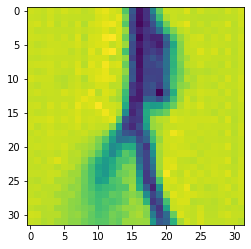

In [19]:
plt.imshow(jnp.squeeze(xpred[0]))

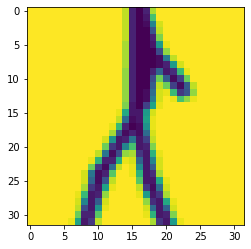

In [20]:
plt.imshow(jnp.squeeze(x[0]))

## Sample multiple times from same input

In [66]:
# small batch size
config.train.batch_size = 1
train_ds, val_ds = data.setup_data(config,show_grid=False)

20000 training images
20000 training steps per epoch


In [67]:
# keys
num_keys = 9
root = jax.random.PRNGKey(0)
keys = jax.random.split(root, num=num_keys)

In [68]:
def sample(key, y):
    (xpred, _), logqw, logpw = hypermodel.apply(hparams, y, reverse=True,key=key)
    return xpred
get_samples = jax.vmap(sample, in_axes=(0, None))

In [69]:
x,y = next(val_ds)

In [70]:
result = get_samples(keys, y)

In [71]:
result.shape

(9, 1, 32, 32, 1)

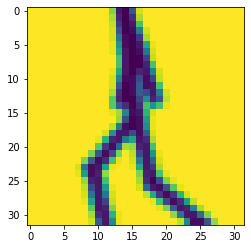

In [72]:
plt.imshow(jnp.squeeze(x[0]))

In [64]:
from mpl_toolkits.axes_grid1 import ImageGrid

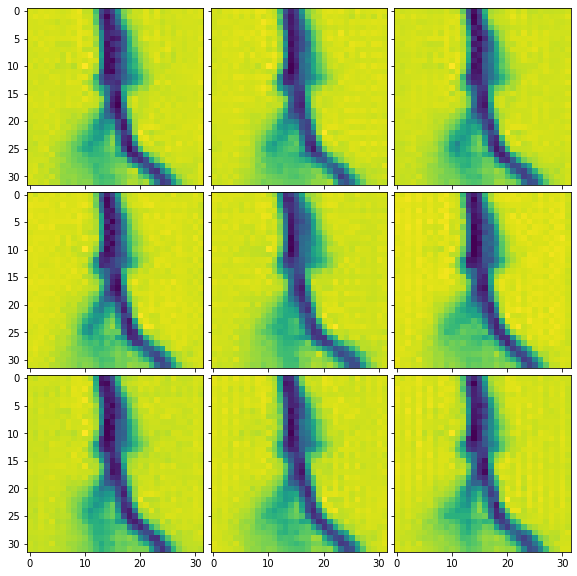

In [75]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
images = [jnp.squeeze(result[i][0]) for i in range(9)]
for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

## Compute variance between samples

In [76]:
config.train.batch_size = 1
train_ds, val_ds = data.setup_data(config,show_grid=False)

20000 training images
20000 training steps per epoch


In [95]:
x,y = next(train_ds)

In [96]:
num_keys = 20
root = jax.random.PRNGKey(0)
keys = jax.random.split(root, num=num_keys)

In [97]:
def sample(key, y):
    (xpred, _), logqw, logpw = hypermodel.apply(hparams, y, reverse=True,key=key)
    return xpred
get_samples = jax.vmap(sample, in_axes=(0, None))

In [98]:
samples = get_samples(keys, y)

In [99]:
samples.shape

(20, 1, 32, 32, 1)

In [100]:
test = jnp.squeeze(samples[0][0])

In [101]:
variance = jnp.var(samples, axis=(0,1))

In [102]:
variance.shape

(32, 32, 1)

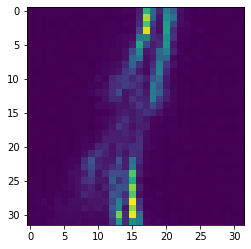

In [103]:
plt.imshow(jnp.squeeze(variance))

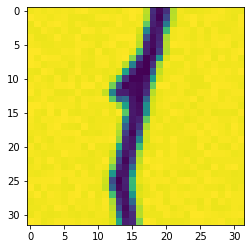

In [104]:
plt.imshow(jnp.squeeze(x[0]))